In [1]:
import sys

parent_dir = 'Predict-Future-Sales'
p_sub = sys.path[0]

ride = ''
for path in p_sub.split('/'):
    if path != parent_dir:
        ride = ride + path + '/'
    else:
        ride = ride + path + '/'
        break
sys.path[0] = ride

In [2]:
import datetime
from typing import Tuple

import numpy as np
from numpy import ndarray
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch
from torch import Tensor

from module.lino_module.preprocess import _mode_of_freq, _src_tgt_split

/Users/lino/opt/anaconda3/envs/for_pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import pickle
import pathlib
import glob

model_path = './models/'
p_file = pathlib.Path(model_path)
file_name = [i.name for i in p_file.iterdir()]

with open (model_path + file_name[0], 'rb') as f:
    obj = pickle.load(f)

In [4]:
def _tde_for_inference(
                    ds: pd.Series,
                    seq: int,
                    d_model: int,
                    dilation: int
                    ) -> np.ndarray:
    for_array = []
    for i in range(d_model):
        if i != 0:
            for_array.append(ds[-seq - i * dilation: -i * dilation])
        else:
            for_array.append(ds[-seq:])
    time_delay_embedded = np.array([content for content in reversed(for_array)])
    return time_delay_embedded

In [5]:
def _inference(model:object, src: Tensor, tgt: Tensor) -> Tensor:
    
    src = torch.from_numpy(src.astype(np.float32)).T.unsqueeze(0)
    tgt = torch.from_numpy(tgt.astype(np.float32)).T.unsqueeze(0)
    model.eval()
    output = model(src, tgt).detach().numpy()#[:, 1, :]
    return output

In [6]:
def recurrent_inference(
                    rec_freq: int,
                    model: object,
                    data: pd.DataFrame,
                    seq: int,
                    d_model: int,
                    dilation: int,
                    src_tgt_seq: Tuple[int, int],
                    ) -> pd.Series:
    """再帰的に推論を行う
    引数: 
        rec_freq: 推論回数
        model: 訓練済みモデル
        data: オリジナルデータ
        seq: 訓練条件の seq
        d_model: 訓練条件の d_model
        dilation: 訓練条件の dilation
        src_tgt_seq: 訓練条件の src_tgt_seq,
    """
    sum_freq = _mode_of_freq(data).item_cnt_day
    start_idx = sum_freq.index[-1] + datetime.timedelta(1)
    scs = StandardScaler().fit(sum_freq.values.reshape(-1, 1))

    src_seq, tgt_seq = src_tgt_seq
    inference_seq = np.array([])
    for _ in range(rec_freq):
        embed = _tde_for_inference(sum_freq, seq, d_model, dilation)
        src, tgt = _src_tgt_split(embed, src_seq, tgt_seq)
        output = _inference(model, src, tgt).reshape(-1)
        inversed = scs.inverse_transform(output[-1].reshape(-1, 1)).reshape(-1)
        sum_freq = np.append(sum_freq, np.round(inversed))
        inference_seq = np.append(inference_seq, np.round(inversed))

    end_idx = start_idx + datetime.timedelta(len(inference_seq) - 1)
    index = pd.date_range(start_idx, end_idx)
    return pd.Series(inference_seq, index)

### Inverse がうまくいってない？ それともデータセット？？ それとも推論???

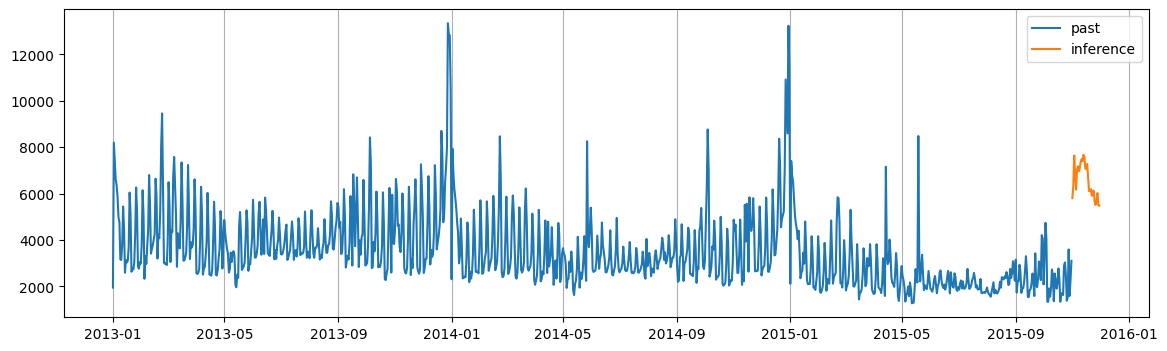

In [8]:
freq = 30
model = obj['model']
env_kwrgs = obj['env']
inference = recurrent_inference(freq, model, **env_kwrgs)
import matplotlib.pyplot as plt

data = pd.read_csv('../data/sales_train.csv')
original = _mode_of_freq(data).item_cnt_day

plt.figure(figsize=(14, 4))
plt.plot(original, label='past')
plt.plot(inference, label='inference')
plt.grid(axis='x')
plt.legend()

In [9]:
inference

2015-11-01    5807.0
2015-11-02    6333.0
2015-11-03    7643.0
2015-11-04    6818.0
2015-11-05    6171.0
2015-11-06    7028.0
2015-11-07    7183.0
2015-11-08    6966.0
2015-11-09    7114.0
2015-11-10    7369.0
2015-11-11    7494.0
2015-11-12    7401.0
2015-11-13    7676.0
2015-11-14    7579.0
2015-11-15    7078.0
2015-11-16    7060.0
2015-11-17    7277.0
2015-11-18    6663.0
2015-11-19    6103.0
2015-11-20    6124.0
2015-11-21    6194.0
2015-11-22    5903.0
2015-11-23    6094.0
2015-11-24    6131.0
2015-11-25    5659.0
2015-11-26    5514.0
2015-11-27    5664.0
2015-11-28    6026.0
2015-11-29    5499.0
2015-11-30    5484.0
Freq: D, dtype: float64